# Descaracterização de Datasets - Dados numéricos e categóricos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

DEFAULT_RANDOM_STATE = 42

In [2]:
# leitura do dataset titanic
dft = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# eliminando qualquer registro com dados faltantes
dft = dft.dropna().reset_index(drop=True)

# eliminando colunas desnecessárias para o exemplo
dft = dft.drop(columns=['PassengerId', 'Name', 'SibSp', 'Ticket', 'Cabin', 'Embarked', 'Parch', 'Fare'])

# alterar Pclass para exemplificar uma variavel categórica ordinal
def pclass(v):
  if v == 1:
    return 'primeira'
  elif v == 2:
    return 'segunda'
  else:
    return 'terceira'
dft['Pclass'] = dft['Pclass'].apply(pclass)

dft.head()

,Survived,Pclass,Sex,Age
0,1,primeira,female,38.0
1,1,primeira,female,35.0
2,0,primeira,male,54.0
3,1,terceira,female,4.0
4,1,primeira,female,58.0


## Variáveis Categóricas

### Não ordinais

In [3]:
dft1 = pd.concat([dft, pd.get_dummies(dft['Sex'])], axis=1).drop(columns='Sex')
dft1.head()

,Survived,Pclass,Age,female,male
0,1,primeira,38.0,1,0
1,1,primeira,35.0,1,0
2,0,primeira,54.0,0,1
3,1,terceira,4.0,1,0
4,1,primeira,58.0,1,0


### Ordinais

In [4]:
le_Pclass = LabelEncoder()
dft1['Pclass'] = le_Pclass.fit_transform(dft1['Pclass'])
dft1.head()

,Survived,Pclass,Age,female,male
0,1,0,38.0,1,0
1,1,0,35.0,1,0
2,0,0,54.0,0,1
3,1,2,4.0,1,0
4,1,0,58.0,1,0


In [5]:
le_Pclass.inverse_transform(dft1['Pclass'].iloc[:10])

array(['primeira', 'primeira', 'primeira', 'terceira', 'primeira',
       'segunda', 'primeira', 'primeira', 'primeira', 'primeira'],
      dtype=object)

## Divisão Treino e Teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dft1.drop(columns='Survived'), dft1['Survived'], test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=dft1['Survived'])

## Variáveis Numéricas

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train[['Age']])

X_train[['Age']] = scaler.transform(X_train[['Age']])
X_test[['Age']] = scaler.transform(X_test[['Age']])

X_train.sample(5)

,Pclass,Age,female,male
129,0,1.000000,0,1
180,0,0.696510,1,0
112,0,0.203338,0,1
146,0,0.291856,1,0
30,1,0.001012,0,1


In [8]:
X_test.sample(5)

,Pclass,Age,female,male
11,1,0.355083,1,0
35,0,0.494183,0,1
67,0,0.355083,0,1
113,0,0.595346,1,0
46,0,0.494183,0,1


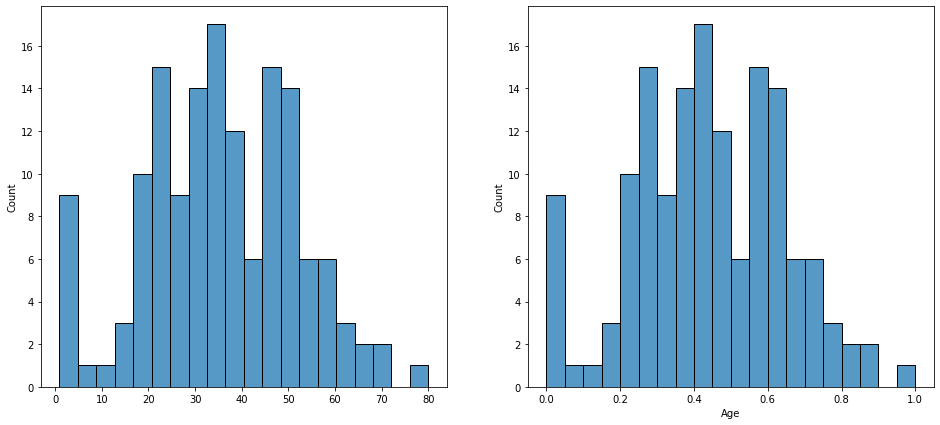

In [9]:
# Apesar da mudança de escala é possível perceber que a distribuição dos dados é preservada

fig, ax = plt.subplots(1,2, figsize=(16, 7))

x = scaler.inverse_transform(X_train[['Age']])[:, 0]
sns.histplot(x, ax=ax[0], bins=20)

x = X_train['Age']
sns.histplot(x, ax=ax[1], bins=20)

plt.show()

## Montagem dos datasets para disponibilização

In [10]:
X_train.columns = [f'F{i+1}' for i in range(X_train.shape[1])]
X_train_final = pd.concat([X_train, y_train.rename('LABEL')], axis=1)
X_train_final.head()

,F1,F2,F3,F4,LABEL
156,0,0.873546,0,1,0
132,0,0.595346,0,1,1
8,0,0.607992,1,0,1
55,0,0.000000,0,1,1
122,0,0.645928,1,0,1


In [11]:
X_test.columns = [f'F{i+1}' for i in range(X_test.shape[1])]
X_test_final = pd.concat([X_test, y_test.rename('LABEL')], axis=1)
X_test_final.head()

,F1,F2,F3,F4,LABEL
1,0,0.430956,1,0,1
21,0,0.671219,0,1,0
154,0,0.443601,0,1,0
170,0,0.405665,1,0,1
67,0,0.355083,0,1,0


# Descaracterização de Datasets - Dados Textuais

In [12]:
df_fakebr = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv')
df_fakebr = df_fakebr.drop(columns='index')
df_fakebr.head()

,label,preprocessed_news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...


In [13]:
X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(df_fakebr.drop(columns='label'), df_fakebr['label'], test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=df_fakebr['label'])

In [14]:
tfidf = TfidfVectorizer(min_df=5, max_df=.7, max_features=100)
tfidf.fit(X_train_txt['preprocessed_news'])

# retorna matrizes esparsas
X_train_txt_tfidf = tfidf.transform(X_train_txt['preprocessed_news'])
X_test_txt_tfidf = tfidf.transform(X_test_txt['preprocessed_news'])

In [15]:
# transforma novamente em dataframe com nomes das palavras
df_train_txt_tfidf = pd.DataFrame(X_train_txt_tfidf.todense(), columns=list(tfidf.get_feature_names_out()))
df_test_txt_tfidf = pd.DataFrame(X_test_txt_tfidf.todense(), columns=list(tfidf.get_feature_names_out()))

df_train_txt_tfidf.head()

,acordo,afirmou,agora,ainda,alem,ano,anos,antes,apenas,apos,ate,brasil,camara,casa,caso,conta,contra,coreia,corrupcao,decisao,defesa,desde,dia,dias,dilma,dinheiro,disse,diz,dois,durante,empresa,entao,estado,estao,fazer,federal,forma,governo,grande,grupo,...,odebrecht,onde,operacao,outro,outros,pais,parte,paulo,pessoas,pode,policia,politica,porque,presidente,prisao,processo,pt,publico,qualquer,republica,rio,sao,segundo,seguranca,ser,sera,sido,so,sobre,stf,tambem,temer,ter,todos,tres,tribunal,tudo,vai,vez,voce
0,0.176422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.497775,0.000000,0.000000,0.000000,0.000000,0.350918,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.339478,0.202997,0.000000,0.000000,0.137021,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.187569,0.196201,0.542559,0.000000,0.000000,0.000000,0.185975,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.141742,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.129980,0.084008,0.160014,0.350386,0.000000,0.000000,0.073855,0.137485,0.075862,0.000000,0.181688,0.000000,0.191722,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.176625,0.060990,0.218951,0.000000,0.079440,0.0,0.000000,0.256047,0.160055,0.083872,0.070771,0.000000,0.225309,0.092518,0.095861,...,0.0,0.0,0.000000,0.000000,0.083,0.000000,0.000000,0.000000,0.160999,0.000000,0.000000,0.095088,0.165559,0.134850,0.0,0.0,0.000000,0.165779,0.000000,0.000000,0.000000,0.189273,0.140939,0.000000,0.000000,0.0,0.090735,0.000000,0.0,0.000000,0.114866,0.000000,0.000000,0.000000,0.092404,0.000000,0.000000,0.234937,0.000000,0.099225
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112242,0.000000,0.000000,0.000000,0.000000,0.000000,0.367795,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.139357,0.000000,0.000000,0.115554,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.296747,0.000000,0.000,0.000000,0.136320,0.000000,0.000000,0.248269,0.442596,0.000000,0.000000,0.110091,0.0,0.0,0.000000,0.000000,0.000000,0.152334,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.167438,0.281328,0.000000,0.000000,0.136797,0.000000,0.000000,0.153245,0.255735,0.000000,0.000000
3,0.123128,0.000000,0.070149,0.101902,0.065861,0.000000,0.164818,0.070294,0.070606,0.057901,0.107786,0.118948,0.244774,0.071220,0.061228,0.000000,0.000000,0.000000,0.0,0.0,0.218272,0.134642,0.059232,0.000000,0.446139,0.000000,0.095630,0.000000,0.000000,0.062280,0.0,0.071608,0.200736,0.000000,0.000000,0.055483,0.074644,0.058880,0.072533,0.075153,...,0.0,0.0,0.000000,0.071716,0.000,0.114834,0.065454,0.000000,0.000000,0.000000,0.000000,0.074548,0.064898,0.211440,0.0,0.0,0.078087,0.000000,0.285052,0.073143,0.080927,0.049462,0.000000,0.000000,0.235473,0.0,0.284539,0.063617,0.0,0.241186,0.000000,0.221301,0.055309,0.131366,0.000000,0.073978,0.073581,0.000000,0.069136,0.077790
4,0.000000,0.026338,0.000000,0.021127,0.000000,0.000000,0.022781,0.058295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025388,0.000000,0.024409,0.787796,0.0,0.0,0.000000,0.000000,0.000000,0.029373,0.000000,0.000000,0.019827,0.000000,0.105379,0.051649,0.0,0.000000,0.000000,0.000000,0.027265,0.000000,0.030951,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.029737,0.000,0.095233,0.000000,0.000000,0.000000,0.024715,0.000000,0.000000,0.026910,0.043837,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.020510,0.000000,0.033421,0.000000,0.0,0.000000,0.026379,0.0,0.000000,0.018670,0.000000,0.022934,0.000000,0.060078,0.000000,0.000000,0.025458,0.000000,0.000000


## Montagem dos datasets para disponibilização

In [16]:
df_train_txt_tfidf.columns = [f'F{i+1}' for i in range(df_train_txt_tfidf.shape[1])]
df_train_txt_tfidf = pd.concat([df_train_txt_tfidf, y_train.rename('LABEL').reset_index(drop=True)], axis=1)
print(df_train_txt_tfidf.shape)
df_train_txt_tfidf.head()

(5760, 101)


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,...,F62,F63,F64,F65,F66,F67,F68,F69,F70,F71,F72,F73,F74,F75,F76,F77,F78,F79,F80,F81,F82,F83,F84,F85,F86,F87,F88,F89,F90,F91,F92,F93,F94,F95,F96,F97,F98,F99,F100,LABEL
0,0.176422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.497775,0.000000,0.000000,0.000000,0.000000,0.350918,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.339478,0.202997,0.000000,0.000000,0.137021,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000,0.000000,0.187569,0.196201,0.542559,0.000000,0.000000,0.000000,0.185975,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.141742,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.129980,0.084008,0.160014,0.350386,0.000000,0.000000,0.073855,0.137485,0.075862,0.000000,0.181688,0.000000,0.191722,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.176625,0.060990,0.218951,0.000000,0.079440,0.0,0.000000,0.256047,0.160055,0.083872,0.070771,0.000000,0.225309,0.092518,0.095861,...,0.0,0.000000,0.000000,0.083,0.000000,0.000000,0.000000,0.160999,0.000000,0.000000,0.095088,0.165559,0.134850,0.0,0.0,0.000000,0.165779,0.000000,0.000000,0.000000,0.189273,0.140939,0.000000,0.000000,0.0,0.090735,0.000000,0.0,0.000000,0.114866,0.000000,0.000000,0.000000,0.092404,0.000000,0.000000,0.234937,0.000000,0.099225,1.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112242,0.000000,0.000000,0.000000,0.000000,0.000000,0.367795,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.139357,0.000000,0.000000,0.115554,0.000000,0.000000,0.000000,0.000000,...,0.0,0.296747,0.000000,0.000,0.000000,0.136320,0.000000,0.000000,0.248269,0.442596,0.000000,0.000000,0.110091,0.0,0.0,0.000000,0.000000,0.000000,0.152334,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.167438,0.281328,0.000000,0.000000,0.136797,0.000000,0.000000,0.153245,0.255735,0.000000,0.000000,1.0
3,0.123128,0.000000,0.070149,0.101902,0.065861,0.000000,0.164818,0.070294,0.070606,0.057901,0.107786,0.118948,0.244774,0.071220,0.061228,0.000000,0.000000,0.000000,0.0,0.0,0.218272,0.134642,0.059232,0.000000,0.446139,0.000000,0.095630,0.000000,0.000000,0.062280,0.0,0.071608,0.200736,0.000000,0.000000,0.055483,0.074644,0.058880,0.072533,0.075153,...,0.0,0.000000,0.071716,0.000,0.114834,0.065454,0.000000,0.000000,0.000000,0.000000,0.074548,0.064898,0.211440,0.0,0.0,0.078087,0.000000,0.285052,0.073143,0.080927,0.049462,0.000000,0.000000,0.235473,0.0,0.284539,0.063617,0.0,0.241186,0.000000,0.221301,0.055309,0.131366,0.000000,0.073978,0.073581,0.000000,0.069136,0.077790,1.0
4,0.000000,0.026338,0.000000,0.021127,0.000000,0.000000,0.022781,0.058295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025388,0.000000,0.024409,0.787796,0.0,0.0,0.000000,0.000000,0.000000,0.029373,0.000000,0.000000,0.019827,0.000000,0.105379,0.051649,0.0,0.000000,0.000000,0.000000,0.027265,0.000000,0.030951,0.000000,0.000000,0.000000,...,0.0,0.000000,0.029737,0.000,0.095233,0.000000,0.000000,0.000000,0.024715,0.000000,0.000000,0.026910,0.043837,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.020510,0.000000,0.033421,0.000000,0.0,0.000000,0.026379,0.0,0.000000,0.018670,0.000000,0.022934,0.000000,0.060078,0.000000,0.000000,0.025458,0.000000,0.000000,1.0


In [17]:
df_test_txt_tfidf.columns = [f'F{i+1}' for i in range(df_test_txt_tfidf.shape[1])]
df_test_txt_tfidf = pd.concat([df_test_txt_tfidf, y_test.rename('LABEL').reset_index(drop=True)], axis=1)
print(df_test_txt_tfidf.shape)
df_test_txt_tfidf.head()

(1440, 101)


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,...,F62,F63,F64,F65,F66,F67,F68,F69,F70,F71,F72,F73,F74,F75,F76,F77,F78,F79,F80,F81,F82,F83,F84,F85,F86,F87,F88,F89,F90,F91,F92,F93,F94,F95,F96,F97,F98,F99,F100,LABEL
0,0.081634,0.084225,0.000000,0.000000,0.0,0.0,0.000000,0.466047,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.148191,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.063402,0.075871,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.468445,0.096178,0.29896,...,0.000000,0.0,0.0,0.000000,0.076135,0.0,0.000000,0.000000,0.000000,0.0,0.197700,0.000000,0.070092,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.268925,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.073340,0.087096,0.0,0.0,0.0,0.081411,0.000000,0.000000,1.0
1,0.185688,0.000000,0.000000,0.153677,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.897085,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.201818,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.159434,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.222493,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.206878,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.158937,0.175397,0.481246,0.0,0.0,0.0,0.173602,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.311781,0.000000,0.000000,0.000000,0.000000,0.210163,0.0,0.0,0.00000,0.000000,0.0,0.138888,0.000000,0.0,0.187614,0.000000,0.0,0.132789,0.652643,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,0.000000,0.209191,0.000000,0.000000,0.0,0.0,0.090469,0.000000,0.0,0.000000,0.000000,0.000000,0.134357,0.0,0.0,0.0,0.096934,0.000000,0.0,0.0,0.11981,0.0,0.0,0.0,0.489772,0.0,0.157473,0.000000,0.0,0.205112,0.0,0.117917,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.113748,0.0,0.0,0.107152,0.094549,0.0,0.112743,0.103924,0.196298,0.0,0.122758,0.106867,0.174089,0.130264,0.348596,0.128586,0.107009,0.000000,0.0,0.0,0.08145,0.181951,0.0,0.232653,0.000000,0.0,0.104758,0.081937,0.0,0.222436,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.101100,0.113846,0.256195,1.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.277979,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.229556,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.301211,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.286151,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.226099,0.000000,0.0,0.000000,0.477772,0.0,0.000000,0.000000,0.265535,0.000000,0.0,0.0,0.0,0.589513,0.000000,0.000000,0.0


# Exemplo Real

In [18]:
df = pd.read_parquet('https://github.com/fernandosola/eniac2021-article/raw/main/datasets/df_train_de.parquet')
df.head()

,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,F016,F017,F018,F019,F020,F021,F022,F023,F024,F025,F026,F027,F028,F029,F030,F031,F032,F033,F034,F035,F036,F037,F038,F039,...,F088,F089,F090,F091,F092,F093,F094,F095,F096,F097,F098,F099,F100,F101,F102,F103,F104,F105,F106,F107,F108,F109,F110,F111,F112,F113,F114,F115,F116,F117,F118,F119,F120,F121,F122,F123,F124,F125,F126,LABEL
3389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000365,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.000000,0.0,0.0,0.000000,0.0,0.15,0.593243,0.0,0.593243,0
3401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.00,0.014189,0.0,0.014189,0
3275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35,0.000000,0.0,0.0,0.000000,0.0,0.35,0.088514,0.0,0.088514,1
2969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.052632,0.0,0.0,0.166667,0.0,0.15,0.209459,0.0,0.209459,0
402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.00,0.136486,0.0,0.136486,0


In [19]:
df = pd.read_parquet('https://github.com/fernandosola/eniac2021-article/raw/main/datasets/df_train_txt.parquet')
df.head()

,0000,0001,0002,0003,0004,0005,0006,0007,0008,0009,0010,0011,0012,0013,0014,0015,0016,0017,0018,0019,0020,0021,0022,0023,0024,0025,0026,0027,0028,0029,0030,0031,0032,0033,0034,0035,0036,0037,0038,0039,...,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,LABEL
3389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047617,0.0,0.0,0.0,0.0,0.0,0.0,0.044541,0.0,0.0,0.0,0.000000,0.0,0.032212,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.068164,0.043341,0.0,0.0,0.0,0.0,0.036068,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0
3401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0
3275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.157851,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1
2969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.131105,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.068792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058304,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0
402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.109619,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.074071,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.06589,0.0,0.0,0.0,0
